# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [ ]:
from google.colab import drive # Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


### <b>Loading libraries</b>

In [ ]:
import os  # Interact with the operating system and filesystem
import pathlib
import PIL
import PIL.Image
import glob
import re
import cv2
import random  # Random number generator
import numpy as np  # Numerical calculations
import pandas as pd  # For loading data from CSV into DataFrames]
import tensorflow as tf  # TensorFlow main module
import keras # main neural network module
from tensorflow.keras.models import Sequential  # Create sequential layered neural networks
from tensorflow.keras.layers import (
   Input,
   Conv2D,  # 2D convolutional layers for images
   LeakyReLU,  # Activation function layers
   MaxPooling2D,  # Maximum pooling layers
   Flatten,  # Flatten layers into 1D vectors
   Dense,  # Fully connected layer
   Dropout,  # Delete/ignore certain neurons to avoid overfitting
   BatchNormalization  # Normalize layer inputs for improved performance
)
from tensorflow.keras.optimizers import ( # Optimizers
    Adam,
    Adafactor,
    Lamb
)
from tensorflow.keras.utils import to_categorical  # One-hot encoder for categorical features
from tensorflow.keras.losses import CategoricalCrossentropy  # Loss function
from tensorflow.keras.metrics import Accuracy  # Accuracy metric to evaluate model performance
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import OneHotEncoder  # One-hot encoder for categorical features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # encode text category labels
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt  # Create charts
import seaborn as sns # Create visualizations

### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [ ]:
!unzip /content/drive/MyDrive/cell_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144001_cell_44.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144001_cell_63.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144001_cell_72.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144001_cell_84.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144143_cell_1.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144143_cell_119.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144143_cell_132.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144143_cell_170.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144143_cell_185.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144143_cell_190.png  
 extracting: cell_images/train/uninfected/C218ThinF_IMG_20151106_144143_cell_192.png 

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [ ]:
ROOT_DATA_DIR = '/cell_images/train/'

INFECTED_DIR = os.path.join(ROOT_DATA_DIR, 'parasitized')
UNINFECTED_DIR = os.path.join(ROOT_DATA_DIR, 'uninfected')

infected_files = glob.glob(INFECTED_DIR+'/*.png')
uninfected_files = glob.glob(UNINFECTED_DIR+'/*.png')

print(f'Amount of parasitized images: {len(infected_files)}')
print(f'Amount of uninfected images: {len(uninfected_files)}')
print(f'Total Images: {len(infected_files) + len(uninfected_files)}')

train_data_dir = pathlib.Path('/content/cell_images/train/')
test_data_dir = pathlib.Path('/content/cell_images/test/')
train_image_count = len(list(train_data_dir.glob('*/*.png')))
test_image_count = len(list(test_data_dir.glob('*/*.png')))
print('Training set has', train_image_count, 'images and testing set has', test_image_count, 'images.')

batch_size = 32
img_height = 180
img_width = 180

Amount of parasitized images: 0
Amount of uninfected images: 0
Total Images: 0
Training set has 24958 images and testing set has 2600 images.


###<b> Check the shape of train and test images

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=20250802,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=20250802,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24958 files belonging to 2 classes.
Using 19967 files for training.
Found 2600 files belonging to 2 classes.
Using 520 files for validation.


###<b> Check the shape of train and test labels

In [ ]:
train_class_names = train_ds.class_names
val_class_names = val_ds.class_names
print('The classes in the training set are:', train_class_names)
print('The classes in the validation set are:', val_class_names)

The classes in the training set are: ['parasitized', 'uninfected']
The classes in the validation set are: ['parasitized', 'uninfected']


####<b> Observations and insights:</b>
- The training and validation sets have the same classes as expected.


\### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
min_pixel_value = float('inf')
max_pixel_value = float('-inf')

for images, _ in train_ds:
  # Convert tensor to numpy array
  image_array = images.numpy()

  # Find min and max pixel values in the current batch
  batch_min = np.min(image_array)
  batch_max = np.max(image_array)

  # Update overall min and max
  min_pixel_value = min(min_pixel_value, batch_min)
  max_pixel_value = max(max_pixel_value, batch_max)

print(f"Minimum pixel value in training data: {min_pixel_value}")
print(f"Maximum pixel value in training data: {max_pixel_value}")

Minimum pixel value in training data: 0.0
Maximum pixel value in training data: 255.0


####<b> Observations and insights: </b>
- The pixel values span the entire range from lowest possible value to highest possible value.


###<b> Count the number of values in both uninfected and parasitized

In [ ]:
# Count the number of values in both uninfected and parasitized
parasitized_count = 0
uninfected_count = 0

for _, labels in train_ds:
  for label in labels:
    if train_class_names[label] == 'parasitized':
      parasitized_count += 1
    else:
      uninfected_count += 1

print(f"Number of parasitized images in training set: {parasitized_count}")
print(f"Number of uninfected images in training set: {uninfected_count}")

Number of parasitized images in training set: 10060
Number of uninfected images in training set: 9907


###<b>Normalize the images

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, depth=len(train_class_names)))) # Apply one-hot encoding
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, depth=len(val_class_names)))) # Apply one-hot encoding

####<b> Observations and insights:</b>
- The number of parasitized and unifected examples is roughly the same.
- As with most neural networks, the images should be normalized.

###<b> Plot to check if the data is balanced

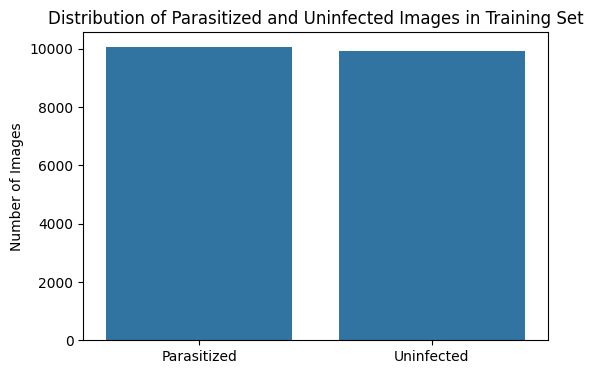

In [ ]:
# Data for plotting
class_counts = {'Parasitized': parasitized_count, 'Uninfected': uninfected_count}
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(6, 4))
sns.barplot(x=classes, y=counts)
plt.title('Distribution of Parasitized and Uninfected Images in Training Set')
plt.ylabel('Number of Images')
plt.show()

####Observations and insights:###
- The data are roughly balanced



### <b>Data Exploration</b>
Let's visualize the images from the train data

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

(32, 180, 180, 3)
(32,)


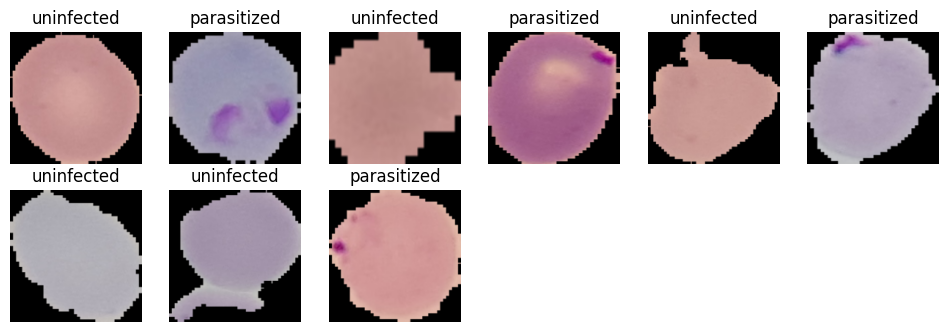

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break



####<b>Observations and insights:

###<b> Plotting the mean images for parasitized and uninfected

<b> Mean image for parasitized

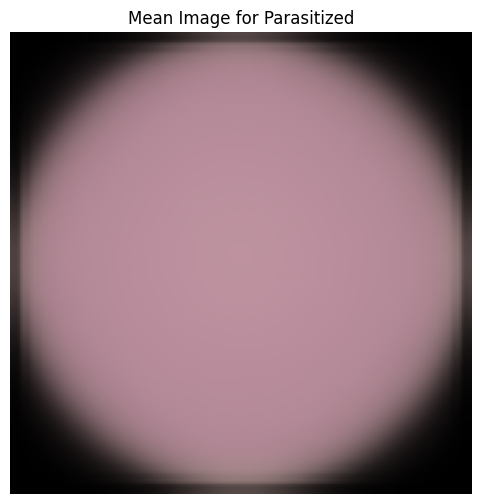

In [ ]:
# Calculate the mean image for parasitized
parasitized_images = []
for images, labels in train_ds:
  for i in range(len(labels)):
    if train_class_names[labels[i]] == 'parasitized':
      parasitized_images.append(images[i].numpy())

mean_parasitized_image = np.mean(parasitized_images, axis=0)
mean_parasitized_image = mean_parasitized_image.astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(mean_parasitized_image)
plt.title('Mean Image for Parasitized')
plt.axis('off')
plt.show()

<b> Mean image for uninfected

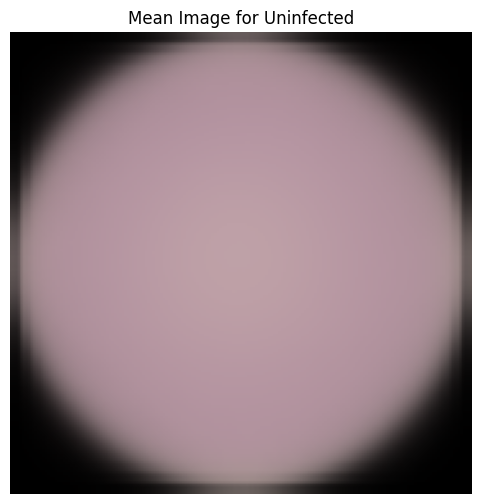

In [ ]:
# Calculate the mean image for uninfected
uninfected_images = []
for images, labels in train_ds:
  for i in range(len(labels)):
    if train_class_names[labels[i]] == 'uninfected':
      uninfected_images.append(images[i].numpy())

mean_uninfected_image = np.mean(uninfected_images, axis=0)
mean_uninfected_image = mean_uninfected_image.astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(mean_uninfected_image)
plt.title('Mean Image for Uninfected')
plt.axis('off')
plt.show()

####<b> Observations and insights:</b>
- The average images are difficult to distinguish.
- Infected cells may be slightly darker on average.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [ ]:
hsv_train_images = []
hsv_train_labels = []

for images, labels in train_ds:
  for i in range(images.shape[0]):
    # Convert RGB to HSV
    hsv_image = cv2.cvtColor(images[i].numpy().astype("uint8"), cv2.COLOR_RGB2HSV)
    hsv_train_images.append(hsv_image)
    hsv_train_labels.append(labels[i].numpy())

# Convert lists to numpy arrays
hsv_train_images = np.array(hsv_train_images)
hsv_train_labels = np.array(hsv_train_labels)

print("Shape of HSV training images:", hsv_train_images.shape)
print("Shape of HSV training labels:", hsv_train_labels.shape)

Shape of HSV training images: (19967, 180, 180, 3)
Shape of HSV training labels: (19967,)


###<b> Converting the test data

In [ ]:
hsv_test_images = []
hsv_test_labels = []

for images, labels in val_ds:
  for i in range(images.shape[0]):
    # Convert RGB to HSV
    hsv_image = cv2.cvtColor(images[i].numpy().astype("uint8"), cv2.COLOR_RGB2HSV)
    hsv_test_images.append(hsv_image)
    hsv_test_labels.append(labels[i].numpy())

# Convert lists to numpy arrays
hsv_test_images = np.array(hsv_test_images)
hsv_test_labels = np.array(hsv_test_labels)

print("Shape of HSV testing images:", hsv_test_images.shape)
print("Shape of HSV testing labels:", hsv_test_labels.shape)

Shape of HSV testing images: (520, 180, 180, 3)
Shape of HSV testing labels: (520,)


####<b>Observations and insights: </b>
- The training and testing images have dimmensions of 180x180 pixels.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [ ]:
blurred_hsv_train_images = []

for image in hsv_train_images:
  # Apply Gaussian blur (kernel size can be adjusted)
  blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
  blurred_hsv_train_images.append(blurred_image)

# Convert list to numpy array
blurred_hsv_train_images = np.array(blurred_hsv_train_images)

print("Shape of blurred HSV training images:", blurred_hsv_train_images.shape)

Shape of blurred HSV training images: (19967, 180, 180, 3)


###<b> Gaussian Blurring on test data

In [ ]:
blurred_hsv_test_images = []

for image in hsv_test_images:
  # Apply Gaussian blur with the same kernel size as the training data
  blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
  blurred_hsv_test_images.append(blurred_image)

# Convert list to numpy array
blurred_hsv_test_images = np.array(blurred_hsv_test_images)

print("Shape of blurred HSV testing images:", blurred_hsv_test_images.shape)

Shape of blurred HSV testing images: (520, 180, 180, 3)


####**Observations and insights: **

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?
- Some images from the real world may be blurry or off-centered

## **Model Building**

### **Base Model**





####<B>One Hot Encoding the train and test labels

In [ ]:
# One-hot encode the training labels
one_hot_train_labels = to_categorical(hsv_train_labels, num_classes=len(train_class_names))

# One-hot encode the testing labels
one_hot_test_labels = to_categorical(hsv_test_labels, num_classes=len(val_class_names))

print("Shape of one-hot encoded training labels:", one_hot_train_labels.shape)
print("Shape of one-hot encoded testing labels:", one_hot_test_labels.shape)

Shape of one-hot encoded training labels: (19967, 2)
Shape of one-hot encoded testing labels: (520, 2)


###<b> Building the model

In [ ]:
#Define the base model
base_model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='silu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='silu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='silu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='silu'),
    Dropout(0.5), # Added dropout layer
    Dense(len(train_class_names), activation='softmax') # Output layer with softmax for classification
])

###<b> Compiling the model

In [ ]:
# Compile the base model
base_model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_base_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

<b> Fit and train our Model

In [ ]:
# Fit and train the base model
history_base = base_model.fit(
    normalized_train_ds,  # Use the normalized and one-hot encoded training dataset
    validation_data=normalized_val_ds, # Use the normalized and one-hot encoded validation dataset
    epochs=20, # You can adjust the number of epochs
    callbacks=callbacks
)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6731 - loss: 0.5874
Epoch 1: val_loss improved from inf to 0.22732, saving model to best_base_model.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.6733 - loss: 0.5871 - val_accuracy: 0.9250 - val_loss: 0.2273
Epoch 2/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9503 - loss: 0.1546
Epoch 2: val_loss improved from 0.22732 to 0.11721, saving model to best_base_model.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9503 - loss: 0.1546 - val_accuracy: 0.9692 - val_loss: 0.1172
Epoch 3/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9682 - loss: 0.1133
Epoch 3: val_loss improved from 0.11721 to 0.09803, saving model to best_base_model.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9683 - loss: 0.1132 - val_accuracy: 0.9692 - val_loss: 0.0980
Epoch 4/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9752 - loss: 0.0758
Epoch 4: val_loss did not improve from 0.09803
624/624 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9752 - loss: 0.0758 - val_accuracy: 0.9769 - val_loss: 0.1166
Epoch 5/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9827 - loss: 0.0564
Epoch 5: val_loss did not improve from 0.09803
624/624 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9827 - loss: 0.0564 - val_accuracy: 0.9731 - val_loss: 0.1238
Epoch 6/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9858 - loss: 0.0438
Epoch 6: val_loss did not improve from 0.09803
624/624 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9858 - loss: 0.0438 - val_accuracy: 0.9654 - val_loss: 0.1822
Epoch 7/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9893 - loss: 0.0339
Epoch 7: val_loss did not improve f

###<b> Evaluating the model on test data

In [ ]:
# Evaluate Model 1 on the test data
base_loss, base_accuracy = base_model.evaluate(normalized_val_ds)

print(f"Base Model Test Loss: {base_loss}")
print(f"Base Model Test Accuracy: {base_accuracy}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9708 - loss: 0.2280
Base Model Test Loss: 0.173906147480011
Base Model Test Accuracy: 0.9730769395828247


<b> Plotting the confusion matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       265
           1       0.48      0.47      0.47       255

    accuracy                           0.49       520
   macro avg       0.49      0.49      0.49       520
weighted avg       0.49      0.49      0.49       520



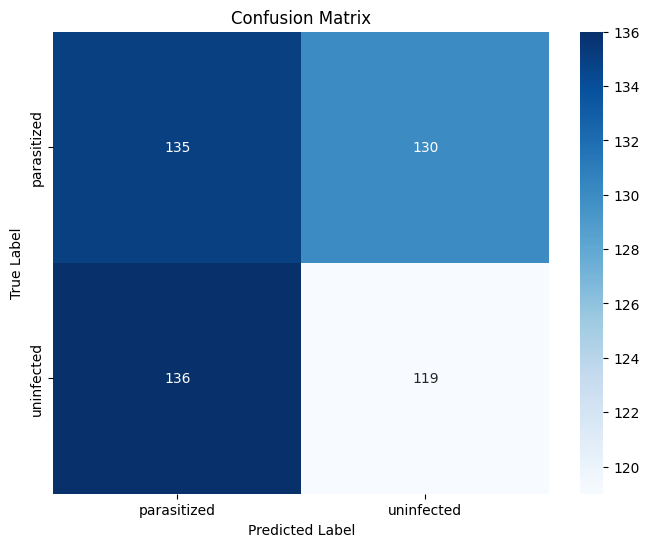

In [ ]:
# Get predictions on the test data
predictions = base_model.predict(normalized_val_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test dataset
true_labels = np.concatenate([y for x, y in normalized_val_ds], axis=0)
true_labels = np.argmax(true_labels, axis=1)

# Generate the confusion matrix
print(classification_report(true_labels, predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_class_names, yticklabels=val_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<b>Plotting the train and validation curves

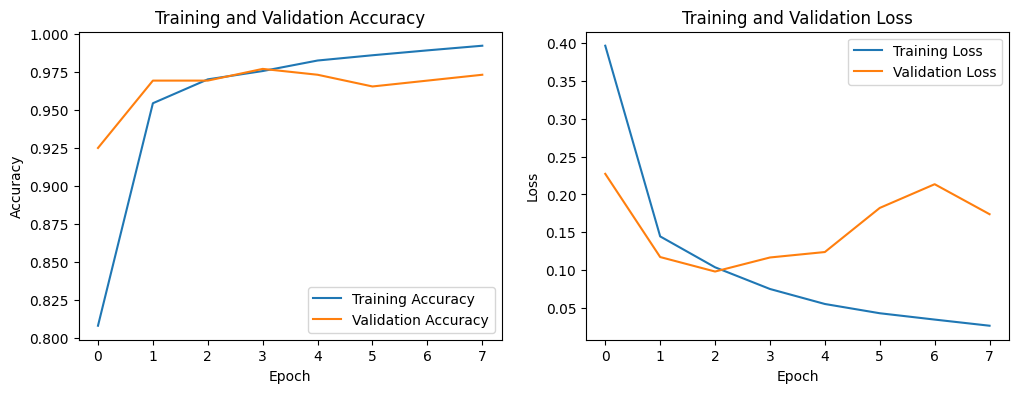

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Training Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Training Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


###<b> Building the Model

In [ ]:
# Define Model 1 with additional layers
model_1 = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='silu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='silu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='silu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='silu'), # Added layer
    MaxPooling2D((2, 2)), # Added layer
    Flatten(),
    Dense(256, activation='silu'), # Increased dense units
    Dropout(0.5), # Added dropout layer
    Dense(128, activation='silu'), # Added dense layer
    Dropout(0.5), # Added dropout layer
    Dense(len(train_class_names), activation='softmax') # Output layer
])

###<b> Compiling the model

In [ ]:
# Compile Model 1
model_1.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,730,242 (21.86 MB)

 Trainable params: 5,730,242 (21.86 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks

In [ ]:
# Define callbacks
model1_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model1.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

<b>Fit and Train the model

In [ ]:
# Fit and train Model 1
history_model_1 = model_1.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=20,
    callbacks=model1_callbacks
)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7028 - loss: 0.5218
Epoch 1: val_loss improved from inf to 0.05201, saving model to best_model1.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.7030 - loss: 0.5215 - val_accuracy: 0.9885 - val_loss: 0.0520
Epoch 2/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9762 - loss: 0.0807
Epoch 2: val_loss did not improve from 0.05201
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9762 - loss: 0.0807 - val_accuracy: 0.9731 - val_loss: 0.0756
Epoch 3/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9786 - loss: 0.0655
Epoch 3: val_loss did not improve from 0.05201
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9786 - loss: 0.0655 - val_accuracy: 0.9865 - val_loss: 0.0594
Epoch 4/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9777 - loss: 0.0622
Epoch 4: val_loss did not improve from 0.05201
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9777 - loss: 0.0622 - val_accuracy: 0.9788 - val_loss: 0.0671
Epoch 5/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9814 - loss: 0.0496
Epoch 5: val_loss did not improve f

###<b> Evaluating the model

In [ ]:
# Evaluate Model 1 on the test data
loss_1, accuracy_1 = model_1.evaluate(normalized_val_ds)

print(f"Model 1 Test Loss: {loss_1}")
print(f"Model 1 Test Accuracy: {accuracy_1}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9869 - loss: 0.0759
Model 1 Test Loss: 0.07841598987579346
Model 1 Test Accuracy: 0.982692301273346


<b> Plotting the confusion matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.50      0.51      0.51       265
           1       0.48      0.48      0.48       255

    accuracy                           0.49       520
   macro avg       0.49      0.49      0.49       520
weighted avg       0.49      0.49      0.49       520



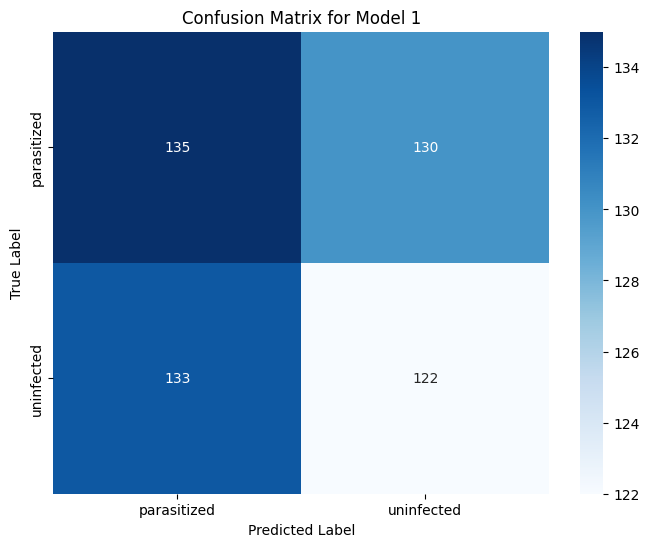

In [ ]:
# Get predictions on the test data for Model 1
predictions_model_1 = model_1.predict(normalized_val_ds)
predicted_labels_model_1 = np.argmax(predictions_model_1, axis=1)

# Generate the confusion matrix for Model 1
print(classification_report(true_labels, predicted_labels_model_1))
cm_model_1 = confusion_matrix(true_labels, predicted_labels_model_1)

# Plot the confusion matrix for Model 1
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model_1, annot=True, fmt='d', cmap='Blues', xticklabels=val_class_names, yticklabels=val_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Model 1')
plt.show()

<b> Plotting the train and the validation curves

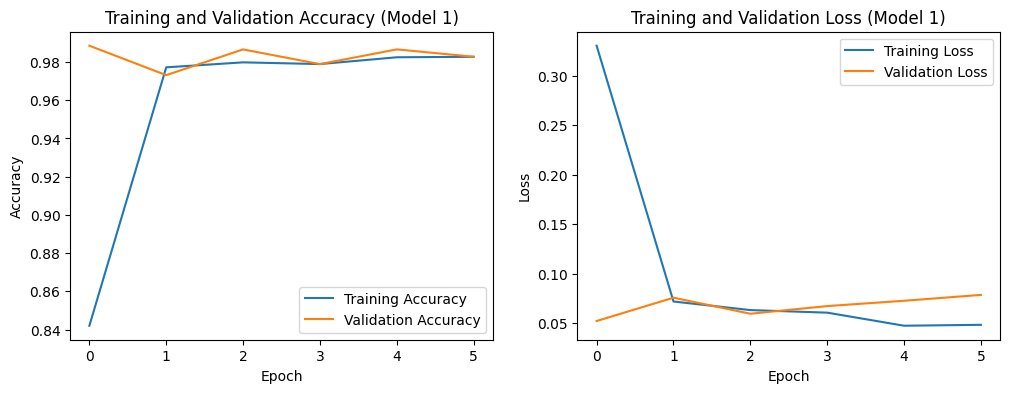

In [ ]:
# Plot training and validation accuracy for Model 1
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_model_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss for Model 1
plt.subplot(1, 2, 2)
plt.plot(history_model_1.history['loss'], label='Training Loss')
plt.plot(history_model_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

###<b> Building the Model

In [ ]:
# Define Model 2 with Batch Normalization and Leaky ReLU
model_2 = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3)),
    BatchNormalization(), # Added Batch Normalization
    LeakyReLU(),          # Using Leaky ReLU activation
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    BatchNormalization(), # Added Batch Normalization
    LeakyReLU(),          # Using Leaky ReLU activation
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3)),
    BatchNormalization(), # Added Batch Normalization
    LeakyReLU(),          # Using Leaky ReLU activation
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128),
    Dropout(0.5), # Added dropout layer
    BatchNormalization(), # Added Batch Normalization
    LeakyReLU(),          # Using Leaky ReLU activation
    Dense(len(train_class_names), activation='softmax') # Output layer with softmax
])

###<b>Compiling the model

In [ ]:
# Compile Model 2
model_2.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,642 (25.36 MB)

 Trainable params: 6,647,938 (25.36 MB)

 Non-trainable params: 704 (2.75 KB)

<b> Using callbacks

In [ ]:
# Define callbacks
model2_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model2.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

<b>Fit and train the model

In [ ]:
# Fit and train Model 2
history_model_2 = model_2.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=20,
    callbacks=model2_callbacks
)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7878 - loss: 0.5339
Epoch 1: val_loss improved from inf to 0.17294, saving model to best_model2.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.7880 - loss: 0.5335 - val_accuracy: 0.9346 - val_loss: 0.1729
Epoch 2/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9407 - loss: 0.1703
Epoch 2: val_loss did not improve from 0.17294
624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9407 - loss: 0.1703 - val_accuracy: 0.9462 - val_loss: 0.1901
Epoch 3/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9491 - loss: 0.1561
Epoch 3: val_loss improved from 0.17294 to 0.12617, saving model to best_model2.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9491 - loss: 0.1560 - val_accuracy: 0.9500 - val_loss: 0.1262
Epoch 4/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9542 - loss: 0.1316
Epoch 4: val_loss improved from 0.12617 to 0.12488, saving model to best_model2.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9542 - loss: 0.1316 - val_accuracy: 0.9615 - val_loss: 0.1249
Epoch 5/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9573 - loss: 0.1259
Epoch 5: val_loss improved from 0.12488 to 0.11902, saving model to best_model2.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9573 - loss: 0.1259 - val_accuracy: 0.9750 - val_loss: 0.1190
Epoch 6/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9652 - loss: 0.1079
Epoch 6: val_loss did not improve from 0.11902
624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9652 - loss: 0.1080 - val_accuracy: 0.9673 - val_loss: 0.1434
Epoch 7/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9649 - loss: 0.1052
Epoch 7: val_loss improved from 0.11902 to 0.10361, saving model to best_model2.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9649 - loss: 0.1051 - val_accuracy: 0.9731 - val_loss: 0.1036
Epoch 8/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9664 - loss: 0.1009
Epoch 8: val_loss did not improve from 0.10361
624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9664 - loss: 0.1008 - val_accuracy: 0.9558 - val_loss: 0.1359
Epoch 9/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9687 - loss: 0.0910
Epoch 9: val_loss improved from 0.10361 to 0.09891, saving model to best_model2.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9687 - loss: 0.0910 - val_accuracy: 0.9750 - val_loss: 0.0989
Epoch 10/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9730 - loss: 0.0808
Epoch 10: val_loss did not improve from 0.09891
624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9730 - loss: 0.0808 - val_accuracy: 0.9712 - val_loss: 0.1259
Epoch 11/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9739 - loss: 0.0812
Epoch 11: val_loss improved from 0.09891 to 0.09388, saving model to best_model2.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9739 - loss: 0.0812 - val_accuracy: 0.9750 - val_loss: 0.0939
Epoch 12/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9742 - loss: 0.0733
Epoch 12: val_loss did not improve from 0.09388
624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9742 - loss: 0.0733 - val_accuracy: 0.9673 - val_loss: 0.1349
Epoch 13/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9782 - loss: 0.0685
Epoch 13: val_loss did not improve from 0.09388
624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9782 - loss: 0.0685 - val_accuracy: 0.9731 - val_loss: 0.1084
Epoch 14/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9792 - loss: 0.0645
Epoch 14: val_loss did not improve from 0.09388
624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9792 - loss: 0.0645 - val_accuracy: 0.9769 - val_loss: 0.1169
Epoch 15/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9793 - loss: 0.0609
Epoch 15: val_loss did not i

####<b>Observations and insights: ____

###<b>Evaluating the model

In [ ]:
# Evaluate Model 2 on the test data
loss_2, accuracy_2 = model_2.evaluate(normalized_val_ds)

print(f"Model 2 Test Loss: {loss_2}")
print(f"Model 2 Test Accuracy: {accuracy_2}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9770 - loss: 0.1289
Model 2 Test Loss: 0.11851044744253159
Model 2 Test Accuracy: 0.9750000238418579


<b> Generate the classification report and confusion matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       265
           1       0.47      0.46      0.46       255

    accuracy                           0.48       520
   macro avg       0.48      0.48      0.48       520
weighted avg       0.48      0.48      0.48       520



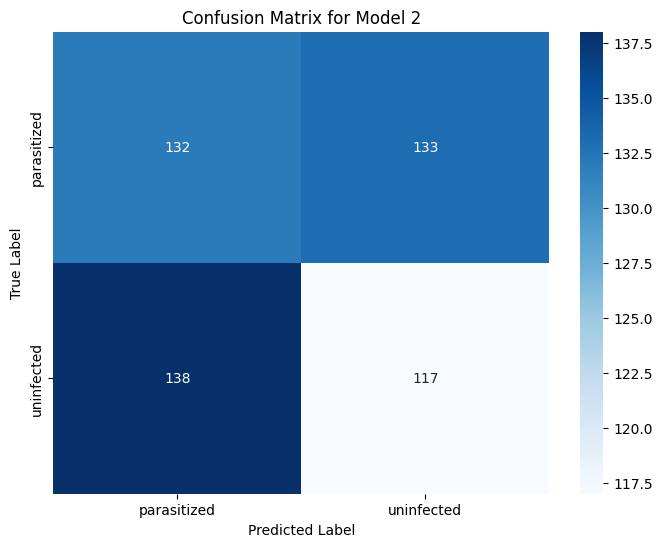

In [ ]:
# Get predictions on the test data for Model 2
predictions_model_2 = model_2.predict(normalized_val_ds)
predicted_labels_model_2 = np.argmax(predictions_model_2, axis=1)

# Generate the confusion matrix for Model 2
print(classification_report(true_labels, predicted_labels_model_2))
cm_model_2 = confusion_matrix(true_labels, predicted_labels_model_2)

# Plot the confusion matrix for Model 2
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model_2, annot=True, fmt='d', cmap='Blues', xticklabels=val_class_names, yticklabels=val_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Model 2')
plt.show()

<b>Plotting the train and validation accuracy

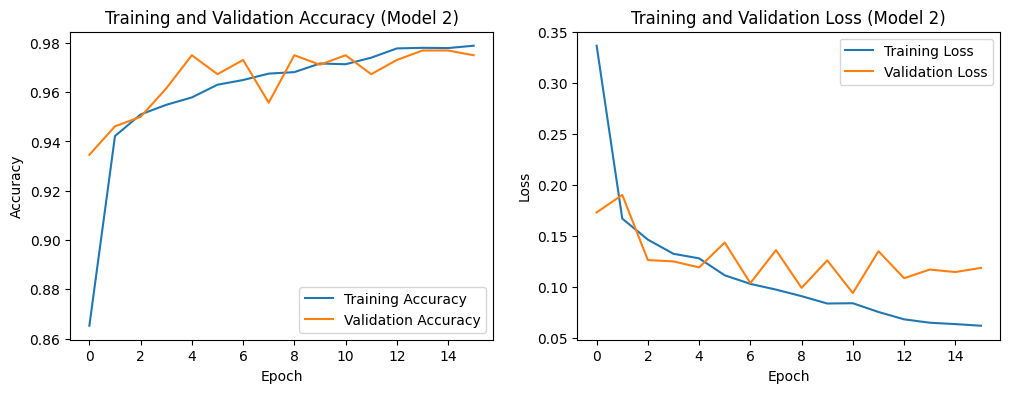

In [ ]:
# Plot training and validation accuracy for Model 2
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_model_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Model 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss for Model 1
plt.subplot(1, 2, 2)
plt.plot(history_model_2.history['loss'], label='Training Loss')
plt.plot(history_model_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Model 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

###<b> Use image data generator

In [ ]:
# Get a sample batch from the training dataset
for images, labels in train_ds.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()

# Use ImageDataGenerator to create augmented samples for visualization
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.05,
    rotation_range=25,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow from the sample batch for visualization
sample_generator = train_datagen.flow(sample_images, sample_labels, batch_size=1)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

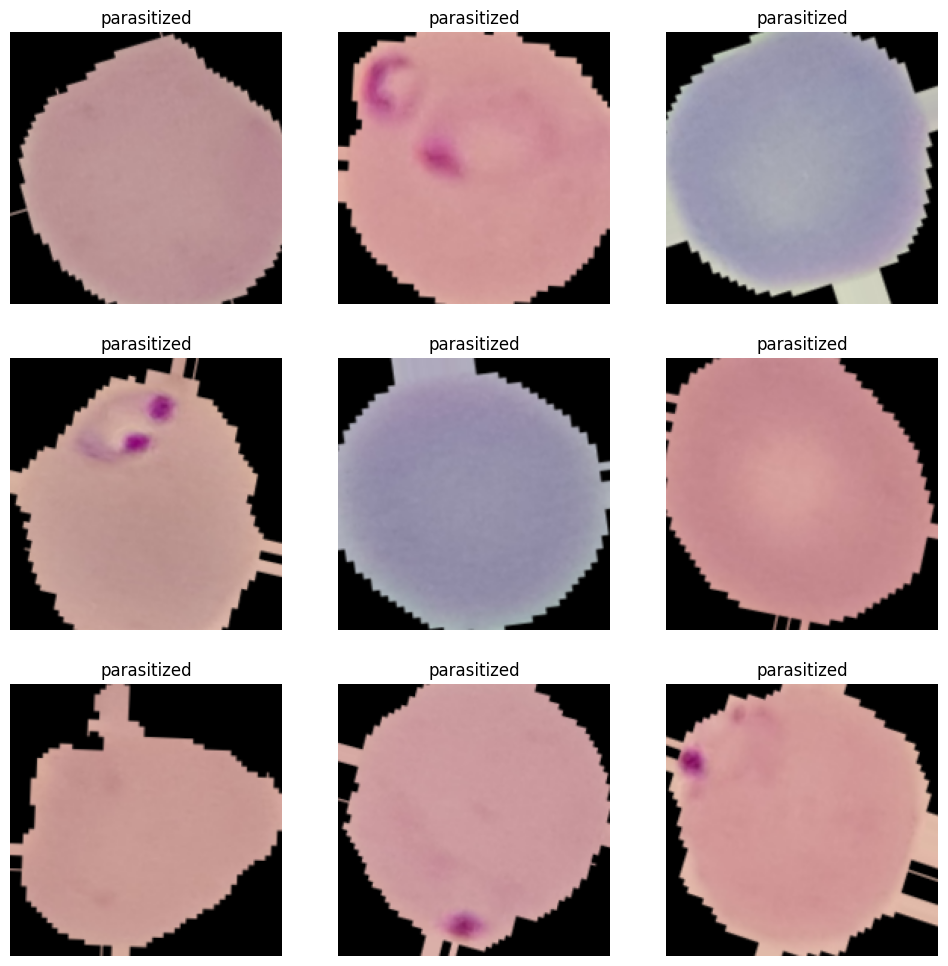

In [ ]:
# Generate and display augmented images
plt.figure(figsize=(12, 12))
for i in range(9):
    augmented_batch = next(sample_generator)
    augmented_image = augmented_batch[0][0].astype('uint8') # Get the image from the batch
    augmented_label = np.argmax(augmented_batch[1][0]) # Get the one-hot encoded label and convert to integer

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.title(train_class_names[augmented_label])
    plt.axis("off")

plt.show()

####<b>Observations and insights: </b>
- The images are recognizeable but appear zoomed in compared to the originals.

###<b>Building the Model

In [ ]:
# Define Model 3 with Batch Normalization and Leaky ReLU
model_3 = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3)),
    BatchNormalization(), # Added Batch Normalization
    LeakyReLU(),          # Using Leaky ReLU activation
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    BatchNormalization(), # Added Batch Normalization
    LeakyReLU(),          # Using Leaky ReLU activation
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3)),
    BatchNormalization(), # Added Batch Normalization
    LeakyReLU(),          # Using Leaky ReLU activation
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128),
    Dropout(0.5), # Added dropout layer
    BatchNormalization(), # Added Batch Normalization
    LeakyReLU(),          # Using Leaky ReLU activation
    Dense(len(train_class_names), activation='softmax') # Output layer with softmax
])

# Compile Model 3
model_3.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model_3.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,642 (25.36 MB)

 Trainable params: 6,647,938 (25.36 MB)

 Non-trainable params: 704 (2.75 KB)

<b>Using Callbacks

In [ ]:
# Define callbacks
model3_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model3.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

<b> Fit and Train the model

In [ ]:
# Fit and train Model 3
history_model_3 = model_3.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=20,
    callbacks=model3_callbacks
)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7674 - loss: 0.5437
Epoch 1: val_loss improved from inf to 0.27994, saving model to best_model3.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.7675 - loss: 0.5434 - val_accuracy: 0.8808 - val_loss: 0.2799
Epoch 2/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9386 - loss: 0.1750
Epoch 2: val_loss improved from 0.27994 to 0.17787, saving model to best_model3.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9386 - loss: 0.1750 - val_accuracy: 0.9538 - val_loss: 0.1779
Epoch 3/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9524 - loss: 0.1408
Epoch 3: val_loss improved from 0.17787 to 0.12279, saving model to best_model3.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9524 - loss: 0.1409 - val_accuracy: 0.9654 - val_loss: 0.1228
Epoch 4/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9589 - loss: 0.1216
Epoch 4: val_loss did not improve from 0.12279
624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9588 - loss: 0.1216 - val_accuracy: 0.9596 - val_loss: 0.1418
Epoch 5/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9614 - loss: 0.1098
Epoch 5: val_loss improved from 0.12279 to 0.11207, saving model to best_model3.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9614 - loss: 0.1098 - val_accuracy: 0.9731 - val_loss: 0.1121
Epoch 6/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9640 - loss: 0.1013
Epoch 6: val_loss improved from 0.11207 to 0.11137, saving model to best_model3.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9640 - loss: 0.1013 - val_accuracy: 0.9635 - val_loss: 0.1114
Epoch 7/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9652 - loss: 0.1010
Epoch 7: val_loss did not improve from 0.11137
624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9652 - loss: 0.1010 - val_accuracy: 0.9692 - val_loss: 0.1217
Epoch 8/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9694 - loss: 0.0854
Epoch 8: val_loss improved from 0.11137 to 0.10622, saving model to best_model3.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9694 - loss: 0.0854 - val_accuracy: 0.9788 - val_loss: 0.1062
Epoch 9/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9701 - loss: 0.0853
Epoch 9: val_loss did not improve from 0.10622
624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9701 - loss: 0.0853 - val_accuracy: 0.9596 - val_loss: 0.1739
Epoch 10/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9723 - loss: 0.0812
Epoch 10: val_loss did not improve from 0.10622
624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9723 - loss: 0.0812 - val_accuracy: 0.9692 - val_loss: 0.1280
Epoch 11/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9749 - loss: 0.0714
Epoch 11: val_loss did not improve from 0.10622
624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9749 - loss: 0.0714 - val_accuracy: 0.9692 - val_loss: 0.1514
Epoch 12/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9794 - loss: 0.0658
Epoch 12: val_loss did not imp

###<B>Evaluating the model

In [ ]:
# Evaluate Model 3 on the test data
loss_3, accuracy_3 = model_3.evaluate(normalized_val_ds)

print(f"Model 3 Test Loss: {loss_3}")
print(f"Model 3 Test Accuracy: {accuracy_3}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9478 - loss: 0.2717
Model 3 Test Loss: 0.20670562982559204
Model 3 Test Accuracy: 0.9557692408561707


<B>Plotting the classification report and confusion matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.52      0.55      0.54       265
           1       0.50      0.47      0.49       255

    accuracy                           0.51       520
   macro avg       0.51      0.51      0.51       520
weighted avg       0.51      0.51      0.51       520



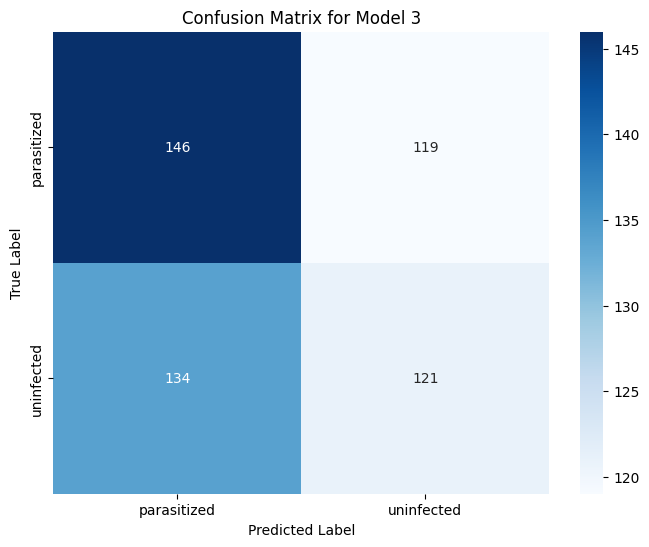

In [ ]:
# Get predictions on the test data for Model 3
predictions_model_3 = model_3.predict(normalized_val_ds)
predicted_labels_model_3 = np.argmax(predictions_model_3, axis=1)

# Generate the confusion matrix for Model 3
print(classification_report(true_labels, predicted_labels_model_3))
cm_model_3 = confusion_matrix(true_labels, predicted_labels_model_3)

# Plot the confusion matrix for Model 3
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model_3, annot=True, fmt='d', cmap='Blues', xticklabels=val_class_names, yticklabels=val_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Model 3')
plt.show()

<b>Plot the train and validation accuracy

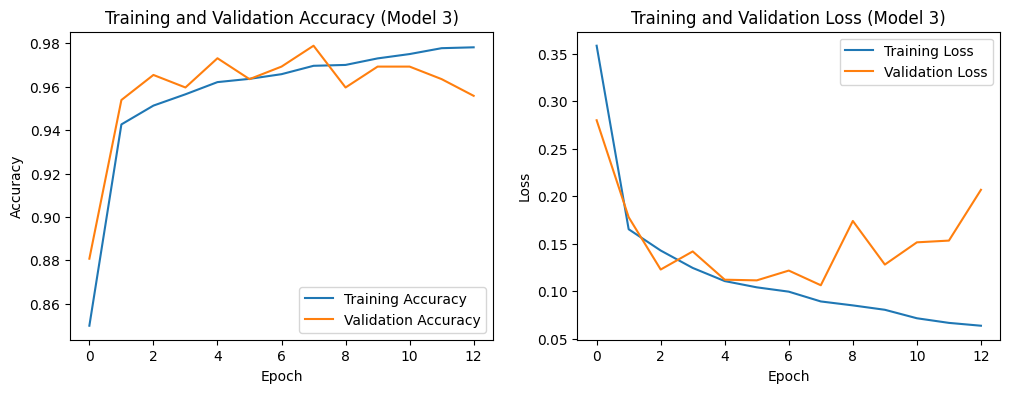

In [ ]:
# Plot training and validation accuracy for Model 3
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_model_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Model 3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss for Model 3
plt.subplot(1, 2, 2)
plt.plot(history_model_3.history['loss'], label='Training Loss')
plt.plot(history_model_3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Model 3)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
# Load VGG16 model without the top classification layer
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers up to layer 20
for layer in vgg.layers[:21]: # Layer 20 is at index 20 (0-based)
    layer.trainable = False

# Create a new sequential model
model_vgg = Sequential()

# Add the layers from VGG16 up to layer 20 (including layer 20)
for layer in vgg.layers[:21]:
    model_vgg.add(layer)

# Add custom classification layers on top
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='silu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(len(train_class_names), activation='softmax'))

model_vgg.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,992,258 (68.64 MB)

 Trainable params: 3,277,570 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

###<b>Compiling the model

In [ ]:
# Compile the VGG16 model
model_vgg.compile(optimizer='adam',
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

<b> using callbacks

In [ ]:
# Define callbacks
model4_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model4.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

<b>Fit and Train the model

In [ ]:
# Fit and train Model 4
history_model_4 = model_vgg.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=20,
    callbacks=model4_callbacks
)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8544 - loss: 0.4625
Epoch 1: val_loss improved from inf to 0.17174, saving model to best_model4.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 89s 137ms/step - accuracy: 0.8544 - loss: 0.4622 - val_accuracy: 0.9269 - val_loss: 0.1717
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9444 - loss: 0.1512
Epoch 2: val_loss improved from 0.17174 to 0.13059, saving model to best_model4.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 84s 135ms/step - accuracy: 0.9444 - loss: 0.1512 - val_accuracy: 0.9538 - val_loss: 0.1306
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9516 - loss: 0.1336
Epoch 3: val_loss did not improve from 0.13059
624/624 ━━━━━━━━━━━━━━━━━━━━ 85s 137ms/step - accuracy: 0.9516 - loss: 0.1336 - val_accuracy: 0.9500 - val_loss: 0.1380
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9581 - loss: 0.1137
Epoch 4: val_loss improved from 0.13059 to 0.11441, saving model to best_model4.h5


624/624 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.9581 - loss: 0.1137 - val_accuracy: 0.9673 - val_loss: 0.1144
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9661 - loss: 0.0997
Epoch 5: val_loss did not improve from 0.11441
624/624 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.9661 - loss: 0.0997 - val_accuracy: 0.9404 - val_loss: 0.1946
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9653 - loss: 0.0960
Epoch 6: val_loss did not improve from 0.11441
624/624 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.9653 - loss: 0.0960 - val_accuracy: 0.9635 - val_loss: 0.1198
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9696 - loss: 0.0887
Epoch 7: val_loss did not improve from 0.11441
624/624 ━━━━━━━━━━━━━━━━━━━━ 85s 137ms/step - accuracy: 0.9696 - loss: 0.0887 - val_accuracy: 0.9596 - val_loss: 0.1283
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9742 - loss: 0.0750
Epoch 8: val_loss did not i

<b>Plot the train and validation accuracy

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9631 - loss: 0.1691
Model 4 Test Loss: 0.13942140340805054
Model 4 Test Accuracy: 0.9653846025466919


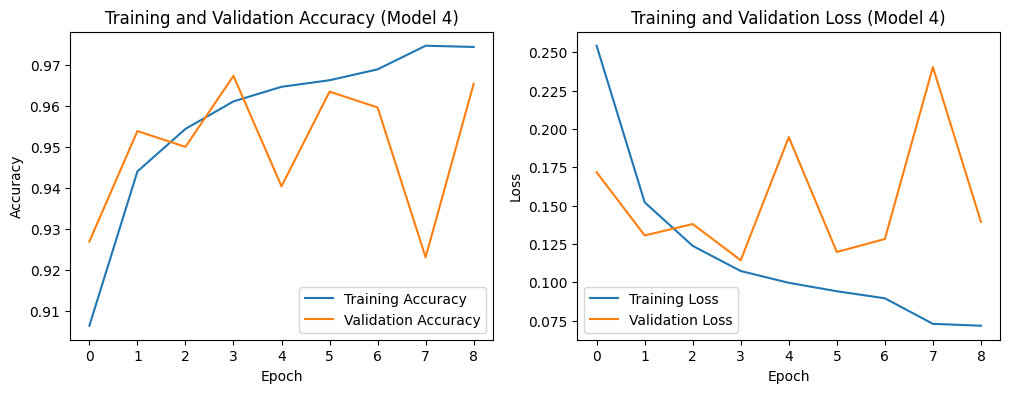

In [ ]:
# Evaluate Model 4 on the test data
loss_4, accuracy_4 = model_vgg.evaluate(normalized_val_ds)

print(f"Model 4 Test Loss: {loss_4}")
print(f"Model 4 Test Accuracy: {accuracy_4}")

# Plot training and validation accuracy for Model 4
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_model_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Model 4)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss for Model 4
plt.subplot(1, 2, 2)
plt.plot(history_model_4.history['loss'], label='Training Loss')
plt.plot(history_model_4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Model 4)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

###**Observations and insights: _____**

*   What can be observed from the validation and train curves?

###<b> Evaluating the model

In [ ]:
# Evaluate Model 4 on the test data
loss_4, accuracy_4 = model_vgg.evaluate(normalized_val_ds)

print(f"Model 4 Test Loss: {loss_4}")
print(f"Model 4 Test Accuracy: {accuracy_4}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9671 - loss: 0.1283
Model 4 Test Loss: 0.13942137360572815
Model 4 Test Accuracy: 0.9653846025466919


<b>Plotting the classification report and confusion matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step
              precision    recall  f1-score   support

           0       0.56      0.57      0.57       265
           1       0.54      0.53      0.53       255

    accuracy                           0.55       520
   macro avg       0.55      0.55      0.55       520
weighted avg       0.55      0.55      0.55       520



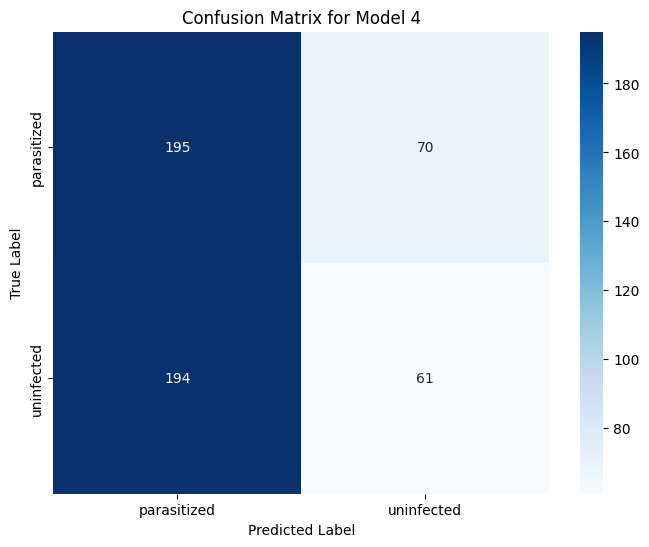

In [ ]:
# Get predictions on the test data for Model 4
predictions_model_4 = model_vgg.predict(normalized_val_ds)
predicted_labels_model_4 = np.argmax(predictions_model_4, axis=1)

# Generate the confusion matrix for Model 4
print(classification_report(true_labels, predicted_labels_model_4))
cm_model_3 = confusion_matrix(true_labels, predicted_labels_model_4)

# Plot the confusion matrix for Model 4
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model_4, annot=True, fmt='d', cmap='Blues', xticklabels=val_class_names, yticklabels=val_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Model 4')
plt.show()

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


####<b> Observations and Conclusions drawn from the final model:</b>
- Although the models are roughly comparable in terms of their F1 scores from the  classification reports, the last model (the pre-trained one) outperformed the others.
- Using data augmentation techniques or a pre-trained model were more successful models compared to our initial approaches.



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?